In [1]:
%matplotlib inline

In [2]:
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from nipype.interfaces import fsl

In [3]:
df = pd.read_csv("/home/julia/workspace/mouse_gradients/regions.csv")
df = df.drop(columns=['Unnamed: 0', 'comment'])
df = df.dropna(axis=0)

In [4]:
data_dir = '/home/julia/data/gradients/'

### Prepare region masks for sampling

In [31]:
for region in df['acronym']:
    resamp = fsl.FLIRT(in_file=data_dir+'allen_atlas/regions/{}.nii.gz'.format(region),
                       reference=data_dir+'allen_atlas/template_200um.nii.gz',
                       apply_isoxfm=0.2,
                       interp='nearestneighbour',
                       out_file=data_dir+'allen_atlas/regions/{}_200um.nii.gz'.format(region))
    resamp.run()

### Sample gradients in regions

In [5]:
gradients = np.array(nb.load(data_dir+'results/embedding/embed.nii.gz').dataobj)[:,:,:,:6]
cortex = np.array(nb.load(data_dir+'allen_atlas/cortex_mask_tight_200um.nii.gz').dataobj)

In [6]:
for g in range(6):
    g_regions = []
    for region in df['acronym']:
        mask = np.array(nb.load(data_dir+'allen_atlas/regions/{}_200um.nii.gz'.format(region)).dataobj)
        g_regions.append(np.mean(gradients[:,:,:,g][mask==1]))
    df['gradient {}'.format(g)] = g_regions

In [7]:
len(df['acronym'])

41

### Correlate cytoarchitectonic type with gradients

Gradient 1: Kendall's tau=-0.01, p=5.8386
Gradient 2: Kendall's tau=-0.39, p=0.3054
Gradient 3: Kendall's tau=0.13, p=3.8186
Gradient 4: Kendall's tau=0.21, p=2.4880
Gradient 5: Kendall's tau=-0.36, p=0.5423
Gradient 6: Kendall's tau=0.25, p=1.4879


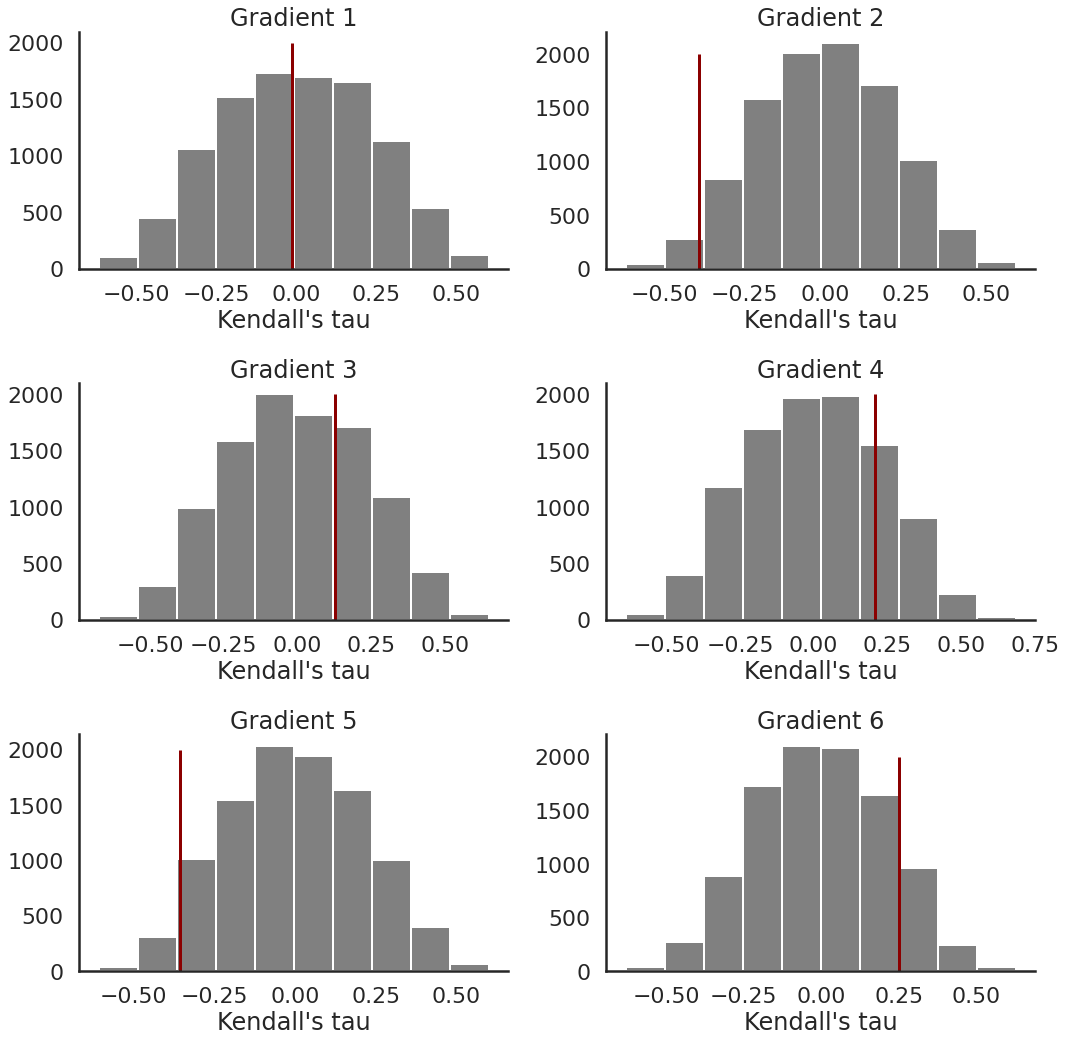

In [8]:
sns.set_style('white')
sns.set_context('poster')
fig = plt.figure(figsize=(15,15))

for g in range(6):
    taus = []
    surrogates = np.load(data_dir + 'results/null_models/volume/surrogates/vol{}_surrogates.npy'.format(g))
    for s in range(10000):
        s_regions = []
        for region in df['acronym']:
            # create a full brain map from the surrogate
            brain_s = np.zeros_like(cortex)
            brain_s[cortex==1] = surrogates[s,:]
            # load the region map 
            mask = np.array(nb.load(data_dir+'allen_atlas/regions/{}_200um.nii.gz'.format(region)).dataobj)
            # sample mean of surrogate in that region
            s_regions.append(np.mean(brain_s[mask==1]))
        # calculate Kendall's tau
        tau, _ = stats.kendalltau(df['type'], s_regions)
        taus.append(tau)
    tau, _ = stats.kendalltau(df['type'], df['gradient {}'.format(g)])
    p_val = np.where(np.abs(taus)>=np.abs(tau))[0].shape[0] / (len(taus)+1) * 6
    print('Gradient {}: Kendall\'s tau={:.2f}, p={:.4f}'.format(g+1, tau, p_val))
    
    
    fig.add_subplot(3,2,g+1)
    plt.hist(taus, color='grey', label='Surrogate maps')
    plt.vlines(tau, 0,2000, color='darkred', label='Gradient {}'.format(g+1))
    plt.xlabel('Kendall\'s tau')
    plt.title('Gradient {}'.format(g+1))
    sns.despine()
plt.tight_layout()

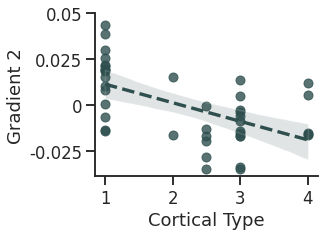

In [19]:
sns.set_style('ticks')
sns.set_context('talk')
c = 'darkslategray'

fig = plt.figure(figsize=(4, 3))
sns.regplot(df['type'], df['gradient 1'], 
            line_kws={'color':c, 
                      'linestyle':'--', },
            scatter_kws={'color':c}, 
            truncate=True,
            fit_reg=True)
plt.yticks([-0.025, 0, 0.025, 0.050], [-0.025, 0, 0.025, 0.050])
plt.xlabel('Cortical Type')
plt.ylabel('Gradient 2')
sns.despine()
plt.savefig('/home/julia/Documents/projects/mouse_gradients/figures/pics/cortical_type.svg')